In [ ]:
!pip install pandas numpy matplotlib ta vaderSentiment scikit-learn
!pip install requests pandas numpy beautifulsoup4


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.9 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=982a4e852ac074b48084de377d9e5cb42d7780a7f6c2d76214e6df87217514f1
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


Data Collection & Preprocessing

Get Historical Price Data

In [ ]:
!pip3 install smartapi-python

In [ ]:
!pip install smartapi-python

In [ ]:
!cat /sys/class/net/eth0/address



02:42:ac:1c:00:0c


In [ ]:
user_name="test"
api_key="gMW5ai8p"
password="be975508-fdae-4db5-a719-e1ff947d4826"
feed_token=None
token_map=None

In [ ]:
!pip install logzero

In [ ]:
!pip install pyotp

In [ ]:
import http.client
import json  # Import json module to parse JSON response

# Setup connection
conn = http.client.HTTPSConnection("apiconnect.angelbroking.com")

# Prepare the payload with your actual details
payload = json.dumps({
    "exchange": "NSE",
    "symboltoken": "3045",  # Update this to the symbol token for the asset you're interested in
    "interval": "ONE_MINUTE",  # Or any other interval you're interested in
    "fromdate": "2021-02-08 09:00",  # Start date and time
    "todate": "2021-02-08 09:16"  # End date and time
})

# Prepare headers with your actual details
headers = {
    'X-PrivateKey': '2ebf4a7e-f1cb-4889-a2b2-6e88c7089269',  # Your SECRET KEY (if required by the API)
    'Accept': 'application/json',
    'X-SourceID': 'WEB',
    'X-ClientLocalIP': '192.168.0.17',  # Replace with your local IP
    'X-ClientPublicIP': '183.83.52.140',  # Replace with your public IP
    'X-MACAddress': 'a0:78:17:b4:71:09',  # Replace with your MAC address
    'X-UserType': 'USER',
    'Authorization': 'Bearer o8k6pnpH',  # Your API KEY
    'Content-Type': 'application/json'
}

# Send the request
conn.request("POST", "/rest/secure/angelbroking/historical/v1/getCandleData", payload, headers)

# Get the response
res = conn.getresponse()
data = res.read()  # Reads the response body

# Decode and print the response
decoded_data = data.decode("utf-8")  # Decode from bytes to string
print(decoded_data)  # Print the raw response

# Optionally, convert the response to a Python dictionary and handle it
try:
    data_dict = json.loads(decoded_data)
    print(json.dumps(data_dict, indent=4))  # Pretty print the JSON
except json.JSONDecodeError:
    print("Failed to decode JSON from response")

{"success":false,"message":"Invalid Token","errorCode":"AG8001","data":""}
{
    "success": false,
    "message": "Invalid Token",
    "errorCode": "AG8001",
    "data": ""
}


Extract Relevant News Articles

In [ ]:
from bs4 import BeautifulSoup
import requests

url = 'https://www.moneycontrol.com/news/tags/nifty.html'

# Fetch the webpage content
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract relevant news articles; adjust the selectors based on actual page structure
articles = soup.find_all('li', class_='clearfix')
news_data = [{'title': str(article.find('p')), 'link': article.find('a')['href']} for article in articles]


In [ ]:
from bs4 import BeautifulSoup
import requests

url = 'https://www.moneycontrol.com/news/tags/nifty50.html'

# Fetch the webpage content
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract relevant news articles; adjust the selectors based on actual page structure
articles = soup.find_all('li', class_='clearfix')
news_data1 = [{'title': str(article.find('p')), 'link': article.find('a')['href']} for article in articles]
news_data.append(news_data1)

Data Preprocessing

In [ ]:
from scipy import stats
import pandas as pd
import numpy as np
df_nifty=pd.read_csv("NSEI.csv")
# Identify and handle outliers for 'close' prices
z_scores = stats.zscore(df_nifty['Close'])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)  # Adjust threshold as needed
df_nifty_clean = df_nifty[filtered_entries]

# Missing value imputation
df_nifty_clean['Close'].fillna(df_nifty_clean['Close'].mean(), inplace=True)

# Normalization
df_nifty_clean['Close'] = (df_nifty_clean['Close'] - df_nifty_clean['Close'].min()) / (df_nifty_clean['Close'].max() - df_nifty_clean['Close'].min())


Feature Selection

Feature Extraction

In [ ]:
import pandas as pd
import numpy as np
from ta import add_all_ta_features
from ta.utils import dropna
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Preprocess DataFrame
df_nifty_clean = dropna(df_nifty_clean)  # Drop rows with NaN values.

# Add financial indicators
df_features = add_all_ta_features(
    df_nifty_clean, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)

# Basic Sentiment Analysis on News Articles (assuming news_data is a list of news article texts)
analyzer = SentimentIntensityAnalyzer()
sentiments = [analyzer.polarity_scores(article['title'])['compound'] for article in news_data]

df_features['news_sentiment'] = pd.Series(sentiments).mean()


In [ ]:
sentiments

[0.4404,
 0.6597,
 0.128,
 0.3818,
 0.743,
 0.5574,
 0.4767,
 0.8074,
 0.0,
 -0.4767,
 0.1477,
 0.0,
 0.9236,
 0.0,
 0.0,
 0.6597,
 0.0772,
 0.4404,
 0.0,
 0.1027,
 0.7003,
 0.0,
 0.0,
 0.7506,
 0.0]

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

# Example function to preprocess text and compute sentiment scores
def compute_sentiment_scores(text):
    analyzer = SentimentIntensityAnalyzer()
    # Preprocessing to remove redundant words can be added here
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']  # Using compound score as an example

# Assuming 'news_articles' is a DataFrame containing your news articles text
news_data[1]['title']


'<p>The monthly options data indicated that 22,300 is expected to be crucial for the further Nifty direction with hurdle on the higher side at near record high levels (which is in between 22,500-22,600 levels), and support at 22,000 mark.</p>'

Statistical Analysis for Feature Selection
python


In [ ]:
df_features['news_sentiment']

0      0.300796
2      0.300796
3      0.300796
4      0.300796
5      0.300796
         ...   
239    0.300796
240    0.300796
241    0.300796
242    0.300796
243    0.300796
Name: news_sentiment, Length: 241, dtype: float64

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare data for feature selection
X = df_features.drop(['Date', 'Close', 'news_sentiment'], axis=1)  # Exclude 'date' and 'close' from features
y = df_features['Close']  # Target variable
X_scaled = MinMaxScaler().fit_transform(X)  # Scale features

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Select top k features based on their correlation with the closing price
selector = SelectKBest(score_func=f_regression, k='all')  # Replace 'all' with desired number of features
selector.fit(X_train, y_train)

# Get the scores for each feature
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)

# Print feature scores
print(feature_scores)


              Feature         Score
3           Adj Close  9.507599e+16
90          others_cr  7.130699e+16
2                 Low  9.399606e+04
1                High  6.772106e+04
0                Open  2.896360e+04
..                ...           ...
60          trend_cci  2.073363e-02
86  momentum_pvo_hist  1.841099e-02
9           volume_em  1.308460e-07
27    volatility_kchi  0.000000e+00
28    volatility_kcli  0.000000e+00

[91 rows x 2 columns]


Model Selection:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Define your LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
6/6 [==============================] - 4s 60ms/step - loss: 0.2301
Epoch 2/25
6/6 [==============================] - 0s 60ms/step - loss: 0.0758
Epoch 3/25
6/6 [==============================] - 0s 59ms/step - loss: 0.0581
Epoch 4/25
6/6 [==============================] - 0s 58ms/step - loss: 0.0604
Epoch 5/25
6/6 [==============================] - 0s 68ms/step - loss: 0.0518
Epoch 6/25
6/6 [==============================] - 1s 105ms/step - loss: 0.0519
Epoch 7/25
6/6 [==============================] - 1s 119ms/step - loss: 0.0494
Epoch 8/25
6/6 [==============================] - 1s 154ms/step - loss: 0.0504
Epoch 9/25
6/6 [==============================] - 1s 195ms/step - loss: 0.0482
Epoch 10/25
6/6 [==============================] - 2s 254ms/step - loss: 0.0488
Epoch 11/25
6/6 [==============================] - 2s 268ms/step - loss: 0.0466
Epoch 12/25
6/6 [==============================] - 1s 251ms/step - loss: 0.0455
Epoch 13/25
6/6 [==============================] - 2s 

In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 6.4 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model


arima_model = ARIMA(df_features['Close'], order=(5,1,0))
arima_result = arima_model.fit()


garch_model = arch_model(df_features['Close'], vol='Garch', p=1, q=1)
garch_result = garch_model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1023569828.5996825
Iteration:      2,   Func. Count:     19,   Neg. LLF: 213625529.29688525
Iteration:      3,   Func. Count:     25,   Neg. LLF: -65.7200071203575
Iteration:      4,   Func. Count:     31,   Neg. LLF: 198.7456437276564
Iteration:      5,   Func. Count:     38,   Neg. LLF: -157.0876147317692
Iteration:      6,   Func. Count:     43,   Neg. LLF: -124.32449003367581
Iteration:      7,   Func. Count:     49,   Neg. LLF: -160.23868713011075
Iteration:      8,   Func. Count:     54,   Neg. LLF: -160.55710011647832
Iteration:      9,   Func. Count:     59,   Neg. LLF: -160.70860231463172
Iteration:     10,   Func. Count:     64,   Neg. LLF: -160.7106063623649
Iteration:     11,   Func. Count:     69,   Neg. LLF: -160.7118774313322
Iteration:     12,   Func. Count:     74,   Neg. LLF: -160.72452873288532
Iteration:     13,   Func. Count:     79,   Neg. LLF: -132.96227061851292
Iteration:     14,   Func. Count:     86,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.06341. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming X_test, y_test are your test datasets
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print(f"MSE: {mse}, RMSE: {rmse}, R-squared: {r_squared}")


2/2 [==============================] - 1s 21ms/step
MSE: 0.006752428340255548, RMSE: 0.08217316070503525, R-squared: 0.9102537299756441


In [ ]:
df_features['Close']

0      0.006135
2      0.023277
3      0.073631
4      0.080542
5      0.109233
         ...   
239    0.920992
240    0.878001
241    0.881907
242    0.913097
243    0.928399
Name: Close, Length: 241, dtype: float64

In [ ]:
from sklearn.preprocessing import StandardScaler
input_features=df_features.drop(['Date', 'Close', 'news_sentiment'], axis=1)
input_features_scaled = StandardScaler().fit_transform(input_features)  # Assuming you've a scaler from preprocessing


df_features['predicted_close'] = np.nan  # Initialize column for predictions
predicted_close = model.predict(input_features_scaled)
df_features['predicted_close'] = predicted_close

8/8 [==============================] - 0s 43ms/step


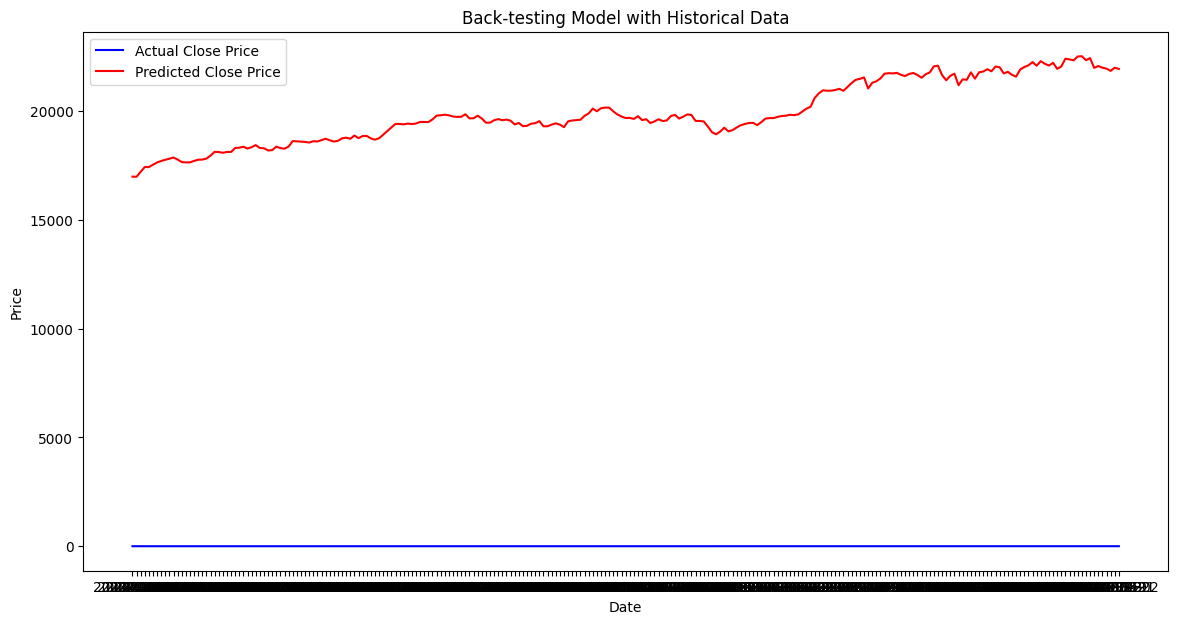

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_features['Date'], df_features['Close'], label='Actual Close Price', color='blue')
plt.plot(df_features['Date'], df_features['Open'], label='Predicted Close Price', color='red')
plt.title('Back-testing Model with Historical Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
